# Example: using Parsl in a physics analysis

### Introduction
This example shows how Parsl can be used in a real physics analysis. It produces the plots shown in the center panels of Fig. 14 of "[Measurement of the cross section for top quark pair production in association with a W or Z boson in proton-proton collisions at s√= 13 TeV](https://arxiv.org/abs/1711.02547)". This example has been derived from the original analysis code which can be found [here](https://github.com/annawoodard/NPFit).

### Import the necessary modules

First, we import the necessary modules. The [parslcms](https://github.com/annawoodard/parslcms) module contains the specialized pieces needed for mounting CVMFS and running [cmssw](https://github.com/cms-sw/cmssw) software inside Parsl apps. The [pnpfit](https://github.com/annawoodard/parslcms) module contains the analysis code.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import parsl

import parslcms.sandbox
from parslcms.configs.midway_ipp import config

import pnpfit
from pnpfit.cards import prepare_cards
from pnpfit.data.config import config as pnpfit_config
from pnpfit.plotting import NLL, tweaks

### Set plotting style

In [2]:
sns.set(context="poster", style="white", font_scale=1.2, rc=tweaks)

### Load the Parsl config

This specifies the computing resources used to run the app. In this example, there are two executors (note that an arbitrary number of different executors can be used). The first executor, which runs more computationally-intensive tasks, uses a pilot job model to submit Slurm jobs to the [Midway Research Computing Center](https://rcc.uchicago.edu) at the University of Chicago. For plotting, a thread pool executor is used, which runs tasks locally. To see the config, execute `print(config)` in a code block. Alternatively, you can view the source [here](https://github.com/annawoodard/parslcms/parslcms/configs/midway_ipp.py).

In [3]:
parsl.clear()
_ = parsl.load(config)

### Configure parameters

Here some parameters are set. A cross

In [4]:
cross_sections = os.path.join(pnpfit.__path__[0], 'data', 'cross_sections/13-TeV/merged/merged.npz')
outdir = os.path.abspath('results')
release = '/home/annawoodard/ttV/CMSSW_8_1_0'
coefficients = ['cuB', 'cH', 'cuW', 'c3G', 'c2G']
processes = ['ttH', 'ttZ', 'ttW']  # processes to scale

### Package the CMSSW user code

This creates a sandbox containing the user's local CMSSW code. This sandbox is shipped out to any loaded executors and unpacked before running apps.

In [5]:
parslcms.sandbox.setup(release)

### Prepare the data cards

This step takes the input datacards from the Standard Model analysis and adds some systematics which are specific to the new physics interpretation.

In [6]:
prepare_cards(pnpfit_config)

### Prepare the inputs and produce the plots
We cycle through the coefficients and for each, instantiate an instance of the `NLL` plot class. We then call the [prepare_inputs](https://github.com/annawoodard/pnpfit/blob/master/pnpfit/plotting.py#L317) method, which calls a series of `cmssw_bash_apps`. The first produces the ROOT workspace and returns a future which is passed to a series of `cmssw_bash_apps` which each calculate the NLL for a chunk of the total scan points; each chunk runs in parallel. These futures are passed to a `cmssw_bash_app` for concatenation. Finally, the [plot](https://github.com/annawoodard/pnpfit/blob/master/pnpfit/plotting.py#L386) method is called, which defines a `python_app` (this time we do not need the CMSSW machinery) which takes the concatenated future as an input and produces the plot. Note that plotting is performed as soon as the inputs are resolved; it is only the final `plot.future.result()` call that is blocking and waits for all apps to complete.

In [7]:
plots = []
for coefficient in coefficients:
    plot = NLL(coefficient, cross_sections, processes)
    plot.prepare_inputs()
    plot.plot()
    plots += [plot]

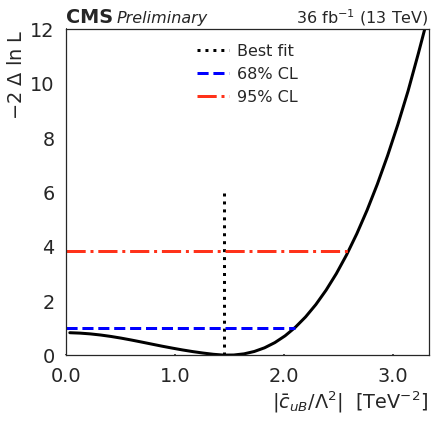

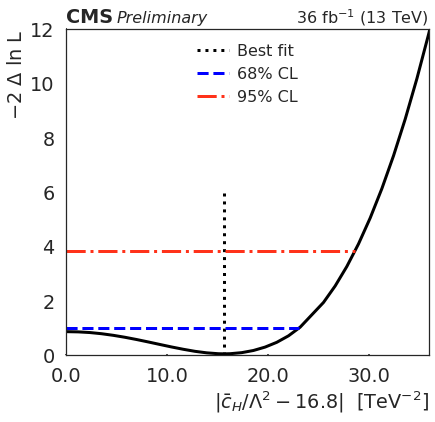

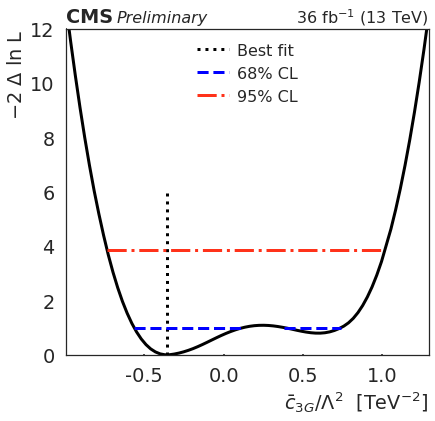

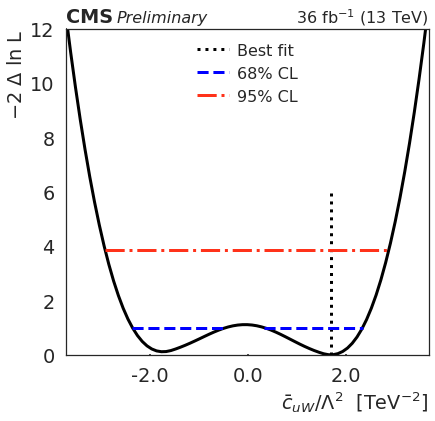

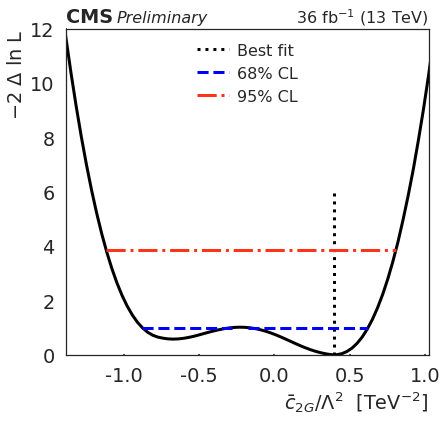

In [8]:
for plot in plots:
    plot.future.result()